In [1]:
from scipy.stats import uniform
u = uniform.rvs(0,1, 10)
print(u)

[0.71474196 0.0084903  0.67482233 0.01065071 0.43335138 0.42700139
 0.96900195 0.13643713 0.46520028 0.02267516]


In [2]:
from scipy.stats import norm
print(norm.rvs(0,1, 50))

[-0.43112517  0.9877069   0.43163597  1.94953481 -1.66097718  2.11215252
 -0.0587944  -0.58089504 -0.71450852  1.14583845 -1.15439718 -0.30062742
  0.11878819 -0.69366595 -0.67419694  0.46943685  0.19990301 -0.02951672
  0.03894268 -0.56127374  0.93607193 -0.33315296  0.79563287  0.68922922
  1.05177831  0.19878902 -0.407319    1.76840651 -0.48552069  2.06082565
 -0.73765482 -0.18467819  0.39635028 -0.39656747 -0.71229815  0.86459764
  1.80307898 -0.83913174 -0.13160538  1.42501907  0.39887807  0.30796085
 -1.63028753 -0.89403867 -1.49060066  2.27983699 -0.92073378 -1.11869772
  0.53854568 -0.28765233]


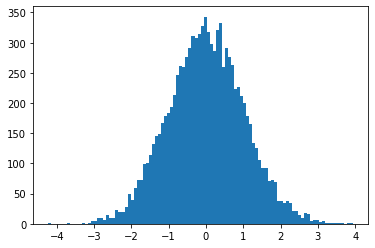

In [3]:
import numpy as np
import matplotlib.pyplot as plt

norm_rv = norm.rvs(0,1, 10000)
plt.hist(norm_rv, 100)
plt.show()

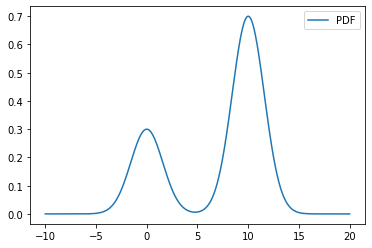

In [4]:
x = np.linspace(-10, 20, 10000)
f_x = 0.3*(np.exp(-0.2*x**2)) + 0.7*(np.exp(-0.2*(x-10)**2))

plt.plot(x, f_x, label="PDF")
plt.legend()
plt.show()

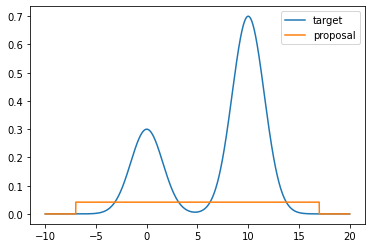

In [5]:
g_x = lambda x: (x > -7 and x < 17)/24
proposal = list(map(g_x, x))

plt.plot(x, f_x, label="target")
plt.plot(x, proposal, label="proposal")
plt.legend()
plt.show()

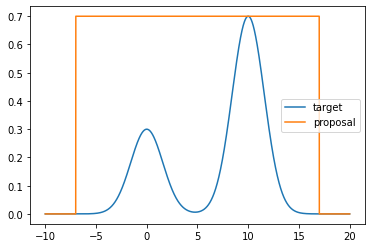

In [6]:
Mg_x = lambda x: (x > -7 and x < 17)/24 * (0.7*24)
M_proposal = list(map(Mg_x, x))

plt.plot(x, f_x, label="target")
plt.plot(x, M_proposal, label="proposal")
plt.legend()
plt.show()

In [7]:
Mg_x = lambda x: (x >= -7 and x <= 17)/24 * (0.7*24)
y = lambda x :0.3*(np.exp(-0.2*x**2)) + 0.7*(np.exp(-0.2*(x-10)**2))
f_alpha = lambda x: y(x)/Mg_x(x)

n = 10000

x_0 = uniform.rvs(-7,24,n)
alpha = list(map(f_alpha, x_0))
coins = np.random.uniform(size=n)

accept = np.where(alpha >= coins)
reject = np.where(alpha < coins)
print(x_0[accept])
print(len(x_0[accept]))

[-1.90199667  8.95708379  8.3601272  ...  9.78876398  9.28456449
 11.36509378]
2377


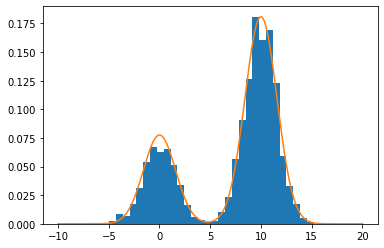

In [8]:
h = plt.hist(x_0[accept], bins=30, density=True)
y_xx = list(map(y, x))
plt.plot(x, y_xx/max(y_xx)*np.max(h[0]))
plt.show()

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [10]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [11]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

In [12]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

In [13]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [14]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

11490434/11490434 [==============================] - 2s 0us/step
Epoch 1/30
547/547 [==============================] - 18s 10ms/step - loss: 259.4988 - reconstruction_loss: 212.5200 - kl_loss: 2.2504
Epoch 2/30
547/547 [==============================] - 5s 9ms/step - loss: 191.7335 - reconstruction_loss: 185.6060 - kl_loss: 3.3013
Epoch 3/30
547/547 [==============================] - 5s 9ms/step - loss: 171.9182 - reconstruction_loss: 163.7687 - kl_loss: 5.5120
Epoch 4/30
547/547 [==============================] - 5s 9ms/step - loss: 164.0175 - reconstruction_loss: 157.3944 - kl_loss: 5.8601
Epoch 5/30
547/547 [==============================] - 5s 9ms/step - loss: 160.6263 - reconstruction_loss: 154.2692 - kl_loss: 6.0790
Epoch 6/30
547/547 [==============================] - 5s 9ms/step - loss: 159.3437 - reconstruction_loss: 152.4676 - kl_loss: 6.1594
Epoch 7/30
547/547 [==============================] - 5s 9ms/step - loss: 157.6072 - reconstruction_loss: 151.0806 - kl_loss: 6.2723
Ep

1/1 [==============================] - 0s 25ms/step


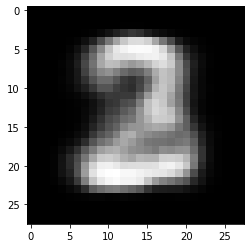

In [29]:
import matplotlib.pyplot as plt

digit_size = 28
scale = 1.0
figure = np.zeros((digit_size, digit_size))

z_sample = np.array([[0.1, -0.1]]) #
x_decoded = vae.decoder.predict(z_sample)
digit = x_decoded[0].reshape(digit_size, digit_size)

figure[
        0 * digit_size : (0 + 1) * digit_size,
        0 * digit_size : (0 + 1) * digit_size,
    ] = digit

plt.figure()
plt.imshow(figure, cmap="Greys_r")
plt.show()